<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [247]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [248]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-06-10 10:46:29--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2019-06-10 10:46:29 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [249]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [250]:
df.shape

(346, 10)

### Convert to date time object 

In [251]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [252]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [253]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



In [255]:
df.Principal.min()

300

In [256]:
df.Principal.max()

1000

In [257]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'loan_status', 'Principal', 'terms',
       'effective_date', 'due_date', 'age', 'education', 'Gender'],
      dtype='object')

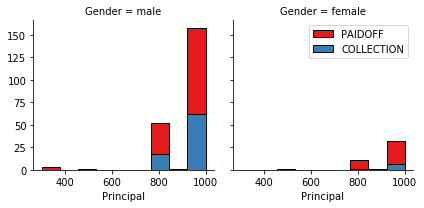

In [258]:
import seaborn as sns

#histogram for Principal, grouped by Gender
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10) #equal space
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2) #col equal column, we have two columsn below, hue = color
g.map(plt.hist, 'Principal', bins=bins, ec="k") # data is principal

g.axes[-1].legend()
plt.show()

In [259]:
bins

array([  300.  ,   377.78,   455.56,   533.33,   611.11,   688.89,
         766.67,   844.44,   922.22,  1000.  ])

In [260]:
377.778 + 77.778

455.55600000000004

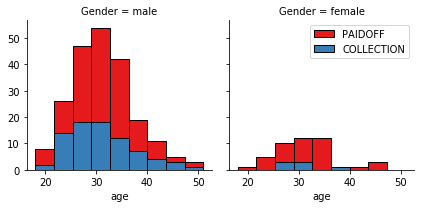

In [261]:
#histogram for age, grouped by Gender
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

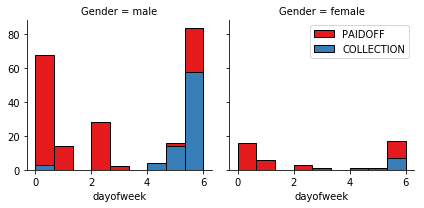

In [262]:
df['dayofweek'] = df['effective_date'].dt.dayofweek #extracting day of the week. NOTE the format of the data column
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k") # data is dayofweek
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [263]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) #1 if dayofweek is 4 or more, else 0
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [264]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True) #groupby gender, loan_status is the column we are interested in.

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [265]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [266]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [267]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [268]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1) #one hot encoding of education


In [269]:
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


In [270]:
#this variable contains many zeros, that is, it is very stable and stable variables do not work well in a machine learning model
Feature['Master or Above'].value_counts()

0    344
1      2
Name: Master or Above, dtype: int64

In [271]:
Feature.drop(['Master or Above'], axis = 1,inplace=True) #drop Master or Above column
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [272]:
X = Feature # independent variable
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [273]:
y = df['loan_status'].values #this is an array, not a series or dataframe
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [274]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

In [275]:
y_train = y
y_train[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [276]:
# Load Necessary libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [277]:
#K nearest neighbor (KNN)
from sklearn.neighbors import KNeighborsClassifier

In [278]:
#Training
#Lets start the algorithm with k=3 for now:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [282]:
#Train Test Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [281]:
#Predicting of first 5 rows of test data

yhat = neigh.predict(X_test)

yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [241]:
# compare with actual value of y
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [242]:
# The model sems to be doing a good Job in classifying the target variable

In [243]:
# Accuracy evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.812138728324
Test set Accuracy:  0.648148148148


In [283]:
# Finding the optimal k

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.67,  0.66,  0.71,  0.69,  0.76,  0.71,  0.79,  0.76,  0.76])

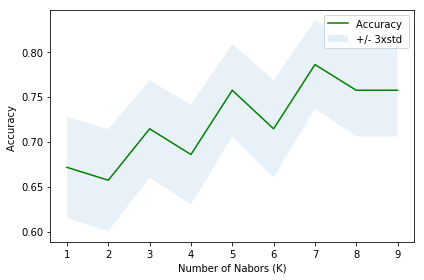

In [284]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [285]:
#Best Accuracy is at K = 7
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.785714285714 with k= 7


In [286]:
# VERY IMPORTANT !!! also find optimal k using gridsearch

In [287]:
# fit the model with K = 7

k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

neigh

# Accuracy evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.807971014493
Test set Accuracy:  0.757142857143


In [288]:
#jaccard Index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.75714285714285712

In [289]:
y_test[0:10]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [290]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

In [291]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION']))

[[48  7]
 [10  5]]


Confusion matrix, without normalization
[[48  7]
 [10  5]]


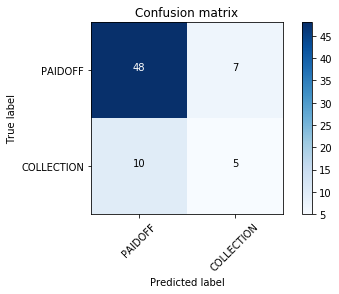

In [292]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [293]:
#Whiles the model does well in predicting PAIDOFF, it does quite poor in predicting Collection

In [294]:
#computing f1 score
print(classification_report(y_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       0.42      0.33      0.37        15
    PAIDOFF       0.83      0.87      0.85        55

avg / total       0.74      0.76      0.75        70



In [295]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') # using weighted here is better since we have more of PAIDOFF class than COLLECTION in the test data

0.74687456103385308

In [296]:
f1_score(y_test, yhat, average='macro') # when we assume all labels are equally important

0.60996394624713213

In [297]:
# log loss
k=7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_prob = neigh.predict_proba(X_test)
yhat_prob
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.46719489000030034

# Decision Tree

In [298]:
# import necessary libraries
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

In [126]:
# Modeling
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
loanTree # it shows the default parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [127]:
#fitting the data with the training feature matrix X_train and training response vector y_train

loanTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [128]:
#prediction
predTree = loanTree.predict(X_test)

In [129]:
print (predTree [0:5])
print (y_test [0:5])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [130]:
#Evaluation
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.614285714286


In [131]:
#Use gridsearch to find the best value for max_depth
from sklearn.model_selection import GridSearchCV

In [148]:
#Define a range for max_depth hyperparametre
max_depth = list(range(1, 20))
param_grid = dict(max_depth = max_depth)

# instantiate the grid
grid = GridSearchCV(loanTree, param_grid, cv=10, scoring='f1_weighted') #we can also replace f1_weighted with jaccard

# fit the grid with data
grid.fit(X_train, y_train)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [149]:
print(grid.best_params_) #best parameter based on f1_weighted

{'max_depth': 3}


In [151]:
#so we fit model using max_depth of 1
# Modeling
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
loanTree # it shows the default parameters

#fitting the data with the training feature matrix X_train and training response vector y_train
loanTree.fit(X_train,y_train)

#prediction
predTree = loanTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.614285714286


In [152]:
#prediction
predTree = loanTree.predict(X_test)

In [153]:
# Indeed, the max_depth seems to be doing a good Job
print (predTree [0:5])
print (y_test [0:5])

['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [154]:
# Plot Confusion matrix

In [155]:
print(confusion_matrix(y_test, predTree, labels=['PAIDOFF','COLLECTION']))

[[36 19]
 [ 8  7]]


In [156]:
cnf_matrix = confusion_matrix(y_test, predTree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[36 19]
 [ 8  7]]


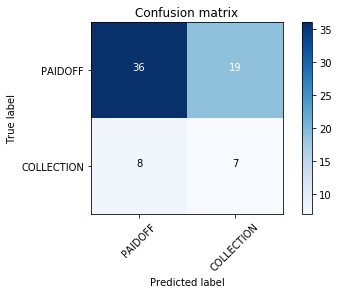

In [157]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [144]:
#Apparently, this is a bad classifier since it predicts each example as PAIDOFF. Other classifiers should be considered

In [158]:
#computing f1 score
print(classification_report(y_test, predTree))

             precision    recall  f1-score   support

 COLLECTION       0.27      0.47      0.34        15
    PAIDOFF       0.82      0.65      0.73        55

avg / total       0.70      0.61      0.64        70



In [159]:
from sklearn.metrics import f1_score
f1_score(y_test, predTree, average='weighted') # using weighted here is better since we have more of PAIDOFF class than COLLECTION in the test data

0.64459930313588854

In [160]:
f1_score(y_test, predTree, average='macro') # when we assume all labels are equally important

0.53436807095343686

In [162]:
# log loss
# Modeling
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
loanTree.fit(X_train,y_train)
predTree_prob = loanTree.predict_proba(X_test)

from sklearn.metrics import log_loss
log_loss(y_test, predTree_prob)

0.92194374123309575

In [ ]:
# very high log loss - indicating bad model

In [163]:
#jaccard Index
from sklearn.metrics import jaccard_similarity_score
predTree = loanTree.predict(X_test)
jaccard_similarity_score(y_test, predTree)

0.61428571428571432

# Support Vector Machine

In [ ]:
#import necessary libraries
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [175]:
#Modelling
from sklearn import svm
clf = svm.SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [176]:
svm_pred = clf.predict(X_test) #predicted values of test data
print(svm_pred[0:5])
print(y_test[0:5])

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [177]:
#confusion matrix
print(confusion_matrix(y_test, svm_pred, labels=['PAIDOFF','COLLECTION']))

[[48  7]
 [11  4]]


Confusion matrix, without normalization
[[48  7]
 [11  4]]


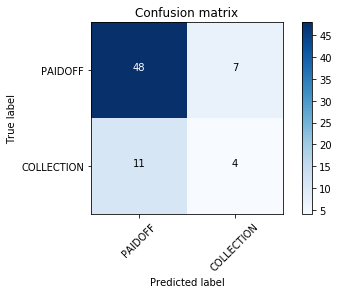

In [178]:
cnf_matrix = confusion_matrix(y_test, svm_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')


In [179]:
#f1 score
print(classification_report(y_test, svm_pred))

             precision    recall  f1-score   support

 COLLECTION       0.36      0.27      0.31        15
    PAIDOFF       0.81      0.87      0.84        55

avg / total       0.72      0.74      0.73        70



In [197]:
from sklearn.metrics import f1_score
f1_score(y_test, svm_pred, average='weighted') # using weighted here is better since we have more of PAIDOFF class than COLLECTION in the test data
#VIP, there is difference between avg/total and average  = weighted

0.72758820127241175

In [198]:
f1_score(y_test, svm_pred, average='macro') # when we assume all labels are equally important

0.5748987854251012

In [184]:
# log loss
svm_pred_prob = clf.predict_proba(X_test) #predicted values of test data
svm_pred_prob
from sklearn.metrics import log_loss
log_loss(y_test, svm_pred_prob)

0.51742809205819296

In [185]:
#jaccard Index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, svm_pred)

0.74285714285714288

In [ ]:
#perform GRID SEARCH FOR SVM

# Logistic Regression

In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [188]:
lr_pred = LR.predict(X_test)
print(lr_pred[0:5])
print(y_test[0:5])

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [190]:
lr_pred_prob = LR.predict_proba(X_test)
lr_pred_prob[0:5]

array([[ 0.5 ,  0.5 ],
       [ 0.45,  0.55],
       [ 0.31,  0.69],
       [ 0.34,  0.66],
       [ 0.32,  0.68]])

In [191]:
#confusion matrix
print(confusion_matrix(y_test, lr_pred, labels=['PAIDOFF','COLLECTION']))

[[46  9]
 [13  2]]


Confusion matrix, without normalization
[[46  9]
 [13  2]]


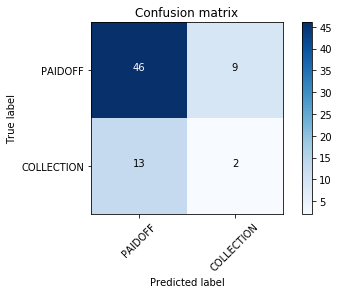

In [192]:
cnf_matrix = confusion_matrix(y_test, lr_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')


In [193]:
#f1 score
print(classification_report(y_test, lr_pred))

             precision    recall  f1-score   support

 COLLECTION       0.18      0.13      0.15        15
    PAIDOFF       0.78      0.84      0.81        55

avg / total       0.65      0.69      0.67        70



In [195]:
from sklearn.metrics import f1_score
f1_score(y_test, lr_pred, average='weighted') # using weighted here is better since we have more of PAIDOFF class than COLLECTION in the test data
#VIP, there is difference between avg/total and average  = weighted

0.66705224599961443

In [196]:
f1_score(y_test, lr_pred, average='macro') # when we assume all labels are equally important

0.48043184885290152

In [199]:
# log loss
#lr_pred_prob is already defined
from sklearn.metrics import log_loss
log_loss(y_test, lr_pred_prob)

0.57722876094796538

In [200]:
#jaccard Index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, lr_pred)

0.68571428571428572

In [ ]:
#PERFORM GRID SEARCH FOR LOGISTIC REGRESSION

# Model Evaluation using Test set

In [210]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [211]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-06-10 10:09:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-06-10 10:09:18 (692 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [212]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [214]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek #extracting day of the week.

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) #1 if dayofweek is 4 or more, else 0


In [208]:
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [215]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [299]:
#Creating X_test and y_test datasets

test_df[['Principal','terms','age','Gender','education']].head()

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1) #one hot encoding of education

Feature_test.drop(['Master or Above'], axis = 1,inplace=True) #drop Master or Above column
Feature_test.head()

XX_test= Feature_test # independent variable

yy_test = test_df['loan_status'].values #this is an array, not a series or dataframe

XX_test= preprocessing.StandardScaler().fit(XX_test).transform(XX_test)

In [304]:
len(test_df)

54

# KNN

In [300]:
yhat = neigh.predict(XX_test)

In [301]:
#jaccard Index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(yy_test, yhat)


0.66666666666666663

In [302]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(yy_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

In [303]:
print(confusion_matrix(yy_test, yhat, labels=['PAIDOFF','COLLECTION']))

[[34  6]
 [12  2]]


Confusion matrix, without normalization
[[34  6]
 [12  2]]


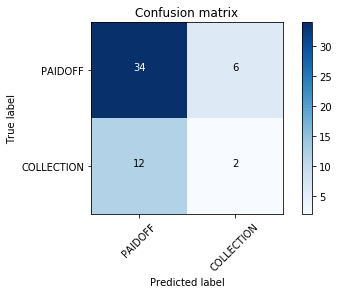

In [305]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [306]:
#computing f1 score
print(classification_report(yy_test, yhat))

             precision    recall  f1-score   support

 COLLECTION       0.25      0.14      0.18        14
    PAIDOFF       0.74      0.85      0.79        40

avg / total       0.61      0.67      0.63        54



In [307]:
from sklearn.metrics import f1_score
f1_score(yy_test, yhat, average='weighted') # using weighted here is better since we have more of PAIDOFF class than COLLECTION in the test data

0.63284002818886542

In [308]:
f1_score(yy_test, yhat, average='macro') # when we assume all labels are equally important


0.48625792811839319

In [309]:
# log loss
k=7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_prob = neigh.predict_proba(XX_test)
yhat_prob
from sklearn.metrics import log_loss
log_loss(yy_test, yhat_prob)


1.0997171539751609

# Decision Tree

In [310]:
#prediction
predTree = loanTree.predict(XX_test)

In [311]:
print(confusion_matrix(yy_test, predTree, labels=['PAIDOFF','COLLECTION']))

[[29 11]
 [ 4 10]]


In [312]:
cnf_matrix = confusion_matrix(yy_test, predTree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[29 11]
 [ 4 10]]


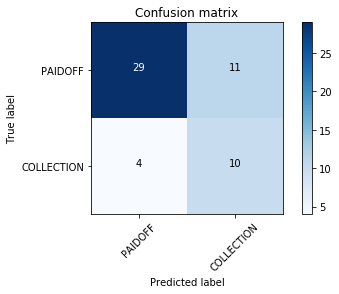

In [313]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [314]:
#computing f1 score
print(classification_report(yy_test, predTree))

             precision    recall  f1-score   support

 COLLECTION       0.48      0.71      0.57        14
    PAIDOFF       0.88      0.72      0.79        40

avg / total       0.77      0.72      0.74        54



In [315]:
from sklearn.metrics import f1_score
f1_score(yy_test, predTree, average='weighted') # using weighted here is better since we have more of PAIDOFF class than COLLECTION in the test data

0.73668188736681883

In [316]:
# log loss
# Modeling
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
loanTree.fit(X_train,y_train)
predTree_prob = loanTree.predict_proba(XX_test)

from sklearn.metrics import log_loss
log_loss(yy_test, predTree_prob)


1.019305984920496

In [318]:
#jaccard Index
from sklearn.metrics import jaccard_similarity_score
predTree = loanTree.predict(XX_test)
jaccard_similarity_score(yy_test, predTree)

0.72222222222222221

# SVM

In [321]:
svm_pred = clf.predict(XX_test) #predicted values of test data


In [322]:
#confusion matrix
print(confusion_matrix(yy_test, svm_pred, labels=['PAIDOFF','COLLECTION']))

[[39  1]
 [10  4]]


Confusion matrix, without normalization
[[39  1]
 [10  4]]


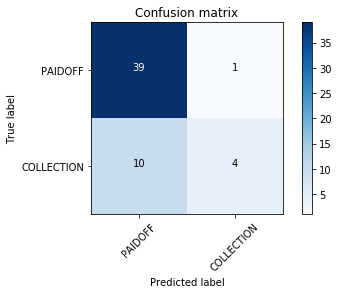

In [323]:
cnf_matrix = confusion_matrix(yy_test, svm_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')


In [324]:
#f1 score
print(classification_report(yy_test, svm_pred))

             precision    recall  f1-score   support

 COLLECTION       0.80      0.29      0.42        14
    PAIDOFF       0.80      0.97      0.88        40

avg / total       0.80      0.80      0.76        54



In [325]:
from sklearn.metrics import f1_score
f1_score(yy_test, svm_pred, average='weighted') # using weighted here is better since we have more of PAIDOFF class than COLLECTION in the test data
#VIP, there is difference between avg/total and average  = weighted


0.7583503077293734

In [326]:
# log loss
svm_pred_prob = clf.predict_proba(XX_test) #predicted values of test data
svm_pred_prob
from sklearn.metrics import log_loss
log_loss(yy_test, svm_pred_prob)


0.52617198557749523

In [327]:
#jaccard Index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(yy_test, svm_pred)

0.79629629629629628

# Logistic Regression

In [328]:
lr_pred = LR.predict(XX_test)

#confusion matrix
print(confusion_matrix(yy_test, lr_pred, labels=['PAIDOFF','COLLECTION']))


[[39  1]
 [13  1]]


[[39  1]
 [13  1]]
Confusion matrix, without normalization
[[39  1]
 [13  1]]


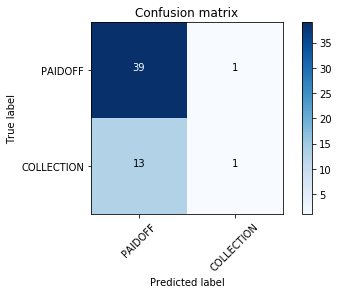

In [329]:
#confusion matrix
print(confusion_matrix(yy_test, lr_pred, labels=['PAIDOFF','COLLECTION']))

cnf_matrix = confusion_matrix(yy_test, lr_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')


In [330]:
#f1 score
print(classification_report(yy_test, lr_pred))


             precision    recall  f1-score   support

 COLLECTION       0.50      0.07      0.12        14
    PAIDOFF       0.75      0.97      0.85        40

avg / total       0.69      0.74      0.66        54



In [331]:
from sklearn.metrics import f1_score
f1_score(yy_test, lr_pred, average='weighted') # using weighted here is better since we have more of PAIDOFF class than COLLECTION in the test data
#VIP, there is difference between avg/total and average  = weighted

0.66042673107890493

In [332]:
lr_pred_prob = LR.predict_proba(XX_test)


In [333]:
# log loss
#lr_pred_prob is already defined
from sklearn.metrics import log_loss
log_loss(yy_test, lr_pred_prob)


0.56721533799129809

In [334]:
#jaccard Index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(yy_test, lr_pred)

0.7407407407407407

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score (weighted) | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.66666666666666663       | 0.63284002818886542        | 1.0997171539751609      |
| Decision Tree      | 0.72222222222222221       | 0.73668188736681883        | 1.019305984920496      |
| SVM                | 0.79629629629629628       | 0.7583503077293734   |0.52617198557749523      |
| LogisticRegression | 0.7407407407407407       | 0.66042673107890493        | 0.56721533799129809       |

# Comparatively, SVM is the best model among these 4 models

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>